In [ ]:
from google.colab import drive
drive.mount('/content/drive');.

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
import os
import cv2
import numpy as np
import json

def extract_flooding_values_from_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    def extract_flooding(data):
        values = {}

        if isinstance(data, dict):
            for key, value in data.items():
                if isinstance(value, dict) and 'filename' in value and 'FLOODING' in value:
                    filename = value['filename']
                    flooding_value = 0 if value['FLOODING'] else 1
                    values[filename] = flooding_value
                else:
                    values.update(extract_flooding(value))
        elif isinstance(data, list):
            for item in data:
                values.update(extract_flooding(item))

        return values

    return extract_flooding(data)
# Load JSON data
s1_data = extract_flooding_values_from_json('/content/drive/MyDrive/dataset/data/SEN12FLOOD/S1list.json')
s2_data = extract_flooding_values_from_json('/content/drive/MyDrive/dataset/data/SEN12FLOOD/S2list.json')

In [ ]:
def read_img(path):
    img = cv2.imread(path)
    img = np.array(img)
    img = img.astype('float32')
    img /= 255.0
    return img

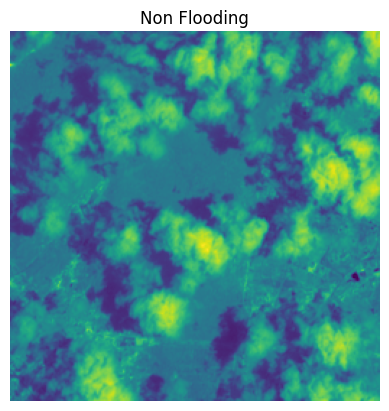

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def visualize_image_with_pillow(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Non Flooding')
    plt.show()
visualize_image_with_pillow('/content/data/SEN12FLOOD/0072/S2_2019-02-04_B8A.tif')

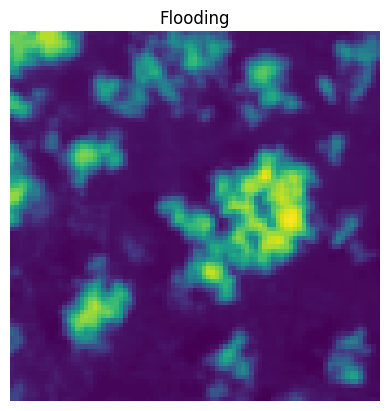

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_image_with_pillow(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title('Flooding')
    plt.axis('off')
    plt.show()
visualize_image_with_pillow('/content/data/SEN12FLOOD/0073/S2_2019-02-04_B01.tif')


In [ ]:
X = []
y = []
c=0
rootdir = '/content/data/SEN12FLOOD'

for folder in os.listdir(rootdir):
    folder_path = os.path.join(rootdir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
          name=file.replace('.tif','')
          img =label= None
          if name[:2]=='S1' and  name[:-13] in s1_data:
              label = s1_data[name[:-13]]
          elif name[:3]=='S2_' and name[:-4] in s2_data:
              label = s2_data[name[:-4]]
          else:
              continue
          c=c+1
          if(c>3000):
            break
            break
          y.append(label)
          X.append(read_img(os.path.join(folder_path, file)))


In [ ]:
import json
json_file_name = '/content/data1/chennai/lab.json'
with open(json_file_name, 'r') as file:
    lab = json.load(file)

In [ ]:
x1=[]
y1=[]

In [ ]:
root1='/content/data1/chennai/data'
i=1
for file in os.listdir(root1):
    img =read_img(os.path.join(root1, file))
    x1.append(img)
    if(f'{i}' in lab):
      y1.append(1)
    else:
      y1.append(0)
    i+=1


In [ ]:
import numpy as np
from skimage.transform import resize
X_arrays = [resize(np.array(item), (128, 128, 3)) for item in X]
x = np.array(X_arrays)
x = np.nan_to_num(x, nan=0.0)
print(x.shape)

/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


(3000, 128, 128, 3)


In [ ]:
import numpy as np
from skimage.transform import resize
X1_arrays = [resize(np.array(item), (128, 128, 3)) for item in x1]
x_1 = np.array(X1_arrays)
x_1 = np.nan_to_num(x_1, nan=0.0)
print(x_1.shape)

(30, 128, 128, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(x_1, y1, test_size=0.2, random_state=42)

In [ ]:
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
print(X_train.shape)
print(y_train.shape)

(2400, 128, 128, 3)
(2400,)


In [ ]:
X1_train = np.asarray(X1_train, dtype=np.float32)
y1_train = np.asarray(y1_train, dtype=np.float32)
print(X1_train.shape)
print(y1_train.shape)

(24, 128, 128, 3)
(24,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf

def create_damnet(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)

    x2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)

    x3 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x2)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x3)

    gap = tf.keras.layers.GlobalAveragePooling2D()(x3)

    fc1 = tf.keras.layers.Dense(512, activation='relu')(gap)
    fc1 = tf.keras.layers.BatchNormalization()(fc1)
    fc1 = tf.keras.layers.Dropout(0.5)(fc1)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(fc1)

    model = tf.keras.Model(inputs, outputs)

    return model

damnet_model = create_damnet(input_shape=(128, 128, 3))

damnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

damnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,820,033 (6.94 MB)

 Trainable params: 1,817,089 (6.93 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
X_train = X_train.reshape((-1, 128, 128, 3))
y_train = y_train.reshape((-1,))

In [ ]:
X1_train = X1_train.reshape((-1, 128, 128, 3))
y1_train = y1_train.reshape((-1,))

In [ ]:
history=damnet_model.fit(X_train,y_train, epochs=20, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.5446 - loss: 0.9996 - val_accuracy: 0.7500 - val_loss: 0.5631
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6010 - loss: 0.7397 - val_accuracy: 0.7500 - val_loss: 0.7221
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6133 - loss: 0.7312 - val_accuracy: 0.7500 - val_loss: 0.7108
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6317 - loss: 0.6921 - val_accuracy: 0.7500 - val_loss: 0.6706
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6693 - loss: 0.6904 - val_accuracy: 0.7500 - val_loss: 0.6694
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6875 - loss: 0.6594 - val_accuracy: 0.7500 - val_loss: 0.6096
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6991 - loss: 0.6822 - val_accuracy: 0.7500 - val_loss: 0.6389
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7169 - loss: 0.6367 - val_accuracy: 0.7500 - 

In [ ]:
history=damnet_model.fit(X1_train,y1_train, epochs=10, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9583 - loss: 0.3352 - val_accuracy: 0.7625 - val_loss: 0.5690
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9583 - loss: 0.3561 - val_accuracy: 0.7500 - val_loss: 0.5777
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8750 - loss: 0.3538 - val_accuracy: 0.7500 - val_loss: 0.5733
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9583 - loss: 0.3190 - val_accuracy: 0.7500 - val_loss: 0.5662
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 1.0000 - loss: 0.3200 - val_accuracy: 0.7500 - val_loss: 0.5684
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9167 - loss: 0.3859 - val_accuracy: 0.7500 - val_loss: 0.5830
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9167 - loss: 0.3597 - val_accuracy: 0.7500 - val_loss: 0.6108
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9583 - loss: 0.3161 - val_accuracy: 0.7500 - val_loss: 0.643

In [ ]:
X_test = X_test.reshape((-1, 128, 128, 3))
X_test = X_test.astype('float32')
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)
loss, accuracy = damnet_model.evaluate(X_test, y_test)
accuracy

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7409 - loss: 0.7544


0.7316666841506958

In [ ]:

damnet_model.save('model_name.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    flatten = layers.Flatten()(conv9)
    outputs = layers.Dense(1, activation='sigmoid')(flatten)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model
unet_model = unet_model()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_13[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 32,080,257 (122.38 MB)

 Trainable params: 32,080,257 (122.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1=unet_model.fit(X_train,y_train, epochs=20, batch_size=16,validation_data=(X_val, y_val))

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 84s 388ms/step - accuracy: 0.6914 - loss: 0.6452 - val_accuracy: 0.7500 - val_loss: 0.5915
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 30s 224ms/step - accuracy: 0.7398 - loss: 0.5817 - val_accuracy: 0.7500 - val_loss: 0.5771
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.7208 - loss: 0.5889 - val_accuracy: 0.7500 - val_loss: 0.5650
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.7252 - loss: 0.5843 - val_accuracy: 0.7500 - val_loss: 0.5780
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.7330 - loss: 0.5792 - val_accuracy: 0.7500 - val_loss: 0.5686
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.7337 - loss: 0.5688 - val_accuracy: 0.7500 - val_loss: 0.5561
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.7213 - loss: 0.5773 - val_accuracy: 0.7500 - val_loss: 0.5519
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.7207 - loss: 0

In [ ]:
history1=unet_model.fit(X1_train,y1_train, epochs=20, batch_size=16,validation_data=(X_val, y_val))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 25s/step - accuracy: 1.0000 - loss: 0.3972 - val_accuracy: 0.7500 - val_loss: 0.5767
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 0.3968 - val_accuracy: 0.7500 - val_loss: 0.5765
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3962 - val_accuracy: 0.7500 - val_loss: 0.5763
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3954 - val_accuracy: 0.7500 - val_loss: 0.5761
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 1.0000 - loss: 0.3946 - val_accuracy: 0.7500 - val_loss: 0.5759
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3936 - val_accuracy: 0.7500 - val_loss: 0.5757
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.0000 - loss: 0.3926 - val_accuracy: 0.7500 - val_loss: 0.5754
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3915 - val_accuracy: 0.7500 - val_loss: 0.5752
Epoch 9/20
2/

In [ ]:
X_test = X_test.reshape((-1, 128, 128, 3))
X_test = X_test.astype('float32')
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)
loss1, accuracy1 = unet_model.evaluate(X_test, y_test)
accuracy1

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 976ms/step - accuracy: 0.7409 - loss: 0.5791


0.7316666841506958

In [ ]:
X1_test = X1_test.reshape((-1, 128, 128, 3))
X1_test = X1_test.astype('float32')
if not isinstance(y1_test, np.ndarray):
    y1_test = np.array(y1_test)
loss1, accuracy1 = unet_model.evaluate(X1_test, y1_test)
accuracy1

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 0.3758


1.0

In [ ]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
# Define the MNASNet model
def create_mnasnet_model(input_shape=(128, 128, 3), num_classes=1):
    # Use 'MobileNetV2' instead of 'MNASNet1_0' if you want to use a similar lightweight model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # We will define our own classification head
        weights='imagenet'  # Load pre-trained weights
    )

    # Freeze the base model
    base_model.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Pool the features from the base model
        layers.Dense(128, activation='relu'),  # Dense layer for classification
        layers.Dropout(0.5),  # Regularization with Dropout
        layers.Dense(num_classes, activation='sigmoid')  # Output layer with sigmoid for binary classification
    ])

    return model

In [ ]:

model = create_mnasnet_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

ValueError: Undefined shapes are not supported.

In [ ]:
history2=model.fit(X_train,y_train, epochs=20, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.6125 - loss: 0.6944 - val_accuracy: 0.6792 - val_loss: 0.6085
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6723 - loss: 0.6280 - val_accuracy: 0.7000 - val_loss: 0.6190
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6965 - loss: 0.6112 - val_accuracy: 0.7042 - val_loss: 0.5868
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6844 - loss: 0.6111 - val_accuracy: 0.6625 - val_loss: 0.6047
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7084 - loss: 0.5879 - val_accuracy: 0.7021 - val_loss: 0.5802
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7206 - loss: 0.5674 - val_accuracy: 0.7188 - val_loss: 0.5571
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7149 - loss: 0.5692 - val_accuracy: 0.7292 - val_loss: 0.5525
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7266 - loss: 0.5594 - val_accuracy: 0.7188 - 

In [ ]:
history2=model.fit(X1_train,y1_train, epochs=10, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5347 - loss: 1.8717 - val_accuracy: 0.6833 - val_loss: 0.6064
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5521 - loss: 1.9170 - val_accuracy: 0.6625 - val_loss: 0.6158
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5938 - loss: 1.2760 - val_accuracy: 0.7312 - val_loss: 0.5414
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5972 - loss: 1.2826 - val_accuracy: 0.7417 - val_loss: 0.5512
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.4792 - loss: 0.9480 - val_accuracy: 0.6896 - val_loss: 0.6110
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.5694 - loss: 0.9398 - val_accuracy: 0.6812 - val_loss: 0.6206
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.6319 - loss: 0.7343 - val_accuracy: 0.7271 - val_loss: 0.6093
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.5521 - loss: 0.7607 - val_accuracy: 0.7542 - val_loss: 0.

In [ ]:
X_test = X_test.reshape((-1, 128, 128, 3))
X_test = X_test.astype('float32')
if not isinstance(y_test, np.ndarray):
    y_test = np.array(y_test)
loss, accuracy2 = model.evaluate(X_test, y_test)
accuracy2

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7099 - loss: 0.6281


0.7283333539962769

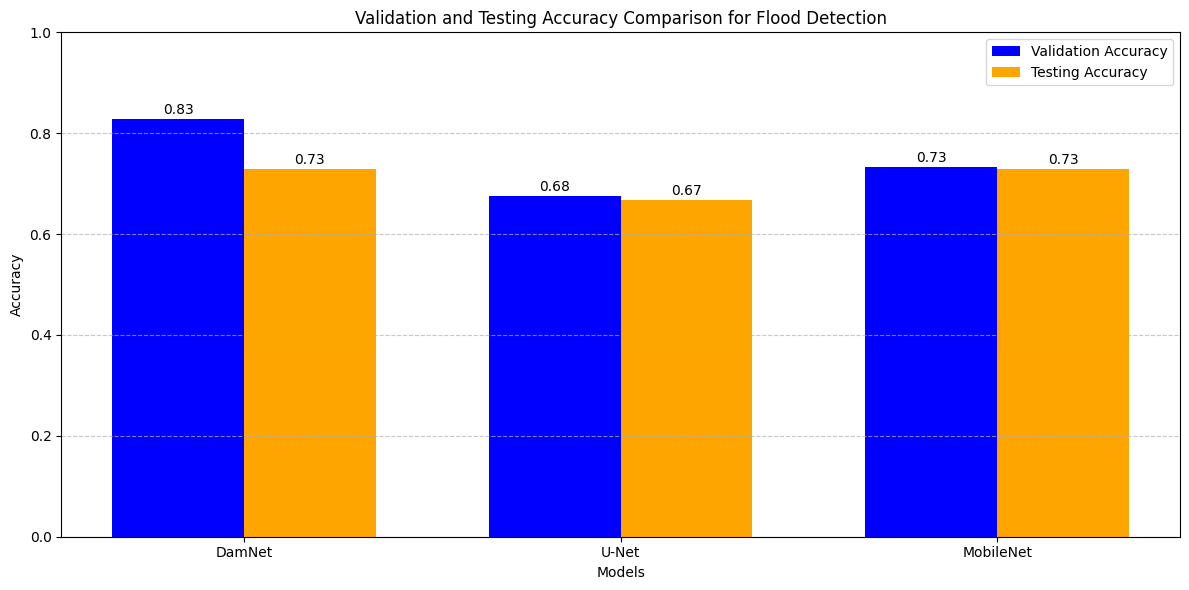

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
models = ['DamNet', 'U-Net', 'MobileNet']
train_accuracies = [history.history['accuracy'][-1],history1.history['val_accuracy'][-1],history2.history['val_accuracy'][-1]]  # Replace with actual training accuracy values
test_accuracies = [accuracy,accuracy1,accuracy2]
bar_width = 0.35
x = np.arange(len(models))
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, train_accuracies, bar_width, label='Validation Accuracy', color='blue')
bars2 = plt.bar(x + bar_width/2, test_accuracies, bar_width, label='Testing Accuracy', color='orange')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Validation and Testing Accuracy Comparison for Flood Detection')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{bar.get_height():.2f}", ha='center')
plt.tight_layout()
plt.show()
